In [33]:
import numpy as np
np.random.seed(42)

In [34]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import os
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder

In [35]:
pwd

'/nfs/home/aifeanyi/COSC_525/Project_3'

In [36]:
#pwd
# Load the training data from a folder
train_dir = "/nfs/home/aifeanyi/COSC_525/Project_3/train"
val_dir = "/nfs/home/aifeanyi/COSC_525/Project_3/val"

num_train = len(os.listdir(train_dir))
num_val = len(os.listdir(val_dir))

num_train,num_val

(86744, 10954)

In [37]:
# Define an empty list to store the image data
img_data_train = []
path = []

# Loop over all files in the folder and load the images
for i in range(num_train):
    img_path = os.path.join(train_dir, f"{i+1}.jpg")
    path.append(img_path)
    img = load_img(img_path, color_mode="grayscale")
    img_array = img_to_array(img)
    img_data_train.append(img_array)

In [38]:
# Define an empty list to store the image data
img_data_val = []
    
# Loop over all files in the folder and load the images
for i in range(num_val):
    img_path = os.path.join(val_dir, f"{i+1}.jpg")
    img = load_img(img_path, color_mode="grayscale")
    img_array = img_to_array(img)
    img_data_val.append(img_array) 

In [39]:
# Convert the list of image arrays to a NumPy array
x_train = np.array(img_data_train)

In [40]:
# Convert the list of image arrays to a NumPy array
x_test = np.array(img_data_val)

In [41]:
 img_width, img_height, img_channels = x_train[0].shape 

In [42]:
# Normalize the pixel values  per channel using min-max normalization
scaler = MinMaxScaler()
x_flat = x_train.reshape(-1, img_channels)
x_train = scaler.fit_transform(x_flat)
x_train = x_train.reshape(-1, img_height, img_width, img_channels)

# Normalize the pixel values using min-max normalization
x_test = scaler.transform(x_test.reshape(-1, img_channels))
x_test = x_test.reshape(-1, img_width, img_height, img_channels)

In [43]:
from keras import backend as K
from keras.layers import Input, Dense, Lambda, Flatten, Reshape
from keras.layers import Conv2D, Conv2DTranspose
from keras.models import Model
from keras.datasets import mnist
from keras.losses import binary_crossentropy, mse
from keras.utils import plot_model
import numpy as np

# Set random seed for reproducibility
np.random.seed(42)


# Define the input shape
image_size = x_train.shape[1]
input_shape = (image_size, image_size, 1)

# Define the number of latent dimensions
latent_dim = 5

# Define the encoder architecture
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
x = Conv2D(32, kernel_size=3, activation='relu', strides=2, padding='same')(x)
x = Conv2D(64, kernel_size=3, activation='relu', strides=2, padding='same')(x)
x = Flatten()(x)
x = Dense(16, activation='relu')(x)

# Define the mean and variance layers
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# Define the sampling function
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=1.)
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

# Use the sampling function to generate a latent vector
z = Lambda(sampling, name='z')([z_mean, z_log_var])

# Define the decoder architecture
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = latent_inputs
x = Dense(8 * 8 * 64, activation='relu')(x)
x = Reshape((8, 8, 64))(x)
x = Conv2DTranspose(64, kernel_size=3, activation='relu', strides=2, padding='same')(x)
x = Conv2DTranspose(32, kernel_size=3, activation='relu', strides=2, padding='same')(x)
outputs = Conv2DTranspose(1, kernel_size=3, activation='sigmoid', padding='same', name='decoder_output')(x)

# Define the VAE model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
decoder = Model(latent_inputs, outputs, name='decoder')
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae')

# Define the reconstruction loss and the KL divergence loss
#reconstruction_loss = K.mean(K.square(inputs - outputs), axis=[1, 2, 3])
reconstruction_loss = mse(K.flatten(inputs), K.flatten(outputs))
#reconstruction_loss = mse(inputs,outputs)
reconstruction_loss *= 1000
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=[-1])
kl_loss *=0.000001
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
#vae.add_loss(mse(inputs,outputs))
from tensorflow.keras.optimizers import Adam
opt = Adam(learning_rate=0.01)
vae.compile(optimizer=opt)

In [44]:
vae.summary()

Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 encoder (Functional)           [(None, 5),          84538       ['encoder_input[0][0]']          
                                 (None, 5),                                                       
                                 (None, 5)]                                                       
                                                                                                  
 decoder (Functional)           (None, 32, 32, 1)    80257       ['encoder[0][2]']                
                                                                                                

In [45]:
history = vae.fit(x_train, epochs=25, batch_size=500, validation_data =(x_test,None))

Epoch 1/25
174/174 [==============================] - 12s 59ms/step - loss: 23.9786 - val_loss: 18.7657
Epoch 2/25
174/174 [==============================] - 10s 59ms/step - loss: 17.3980 - val_loss: 17.5251
Epoch 3/25
174/174 [==============================] - 10s 59ms/step - loss: 17.0538 - val_loss: 17.2498
Epoch 4/25
174/174 [==============================] - 10s 58ms/step - loss: 16.7926 - val_loss: 16.7932
Epoch 5/25
174/174 [==============================] - 10s 59ms/step - loss: 16.6640 - val_loss: 16.6657
Epoch 6/25
174/174 [==============================] - 13s 76ms/step - loss: 16.4868 - val_loss: 16.6161
Epoch 7/25
174/174 [==============================] - 17s 95ms/step - loss: 16.4204 - val_loss: 16.5692
Epoch 8/25
174/174 [==============================] - 16s 94ms/step - loss: 16.3494 - val_loss: 16.5314
Epoch 9/25
174/174 [==============================] - 17s 95ms/step - loss: 16.3051 - val_loss: 16.5542
Epoch 10/25
174/174 [==============================] - 17s 96ms/

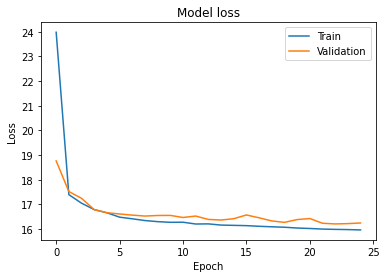

In [46]:
import matplotlib.pyplot as plt
# Plot the loss for each epoch
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()


### Sampling from standard normal distribution

In [47]:
# Generate images from standard normal distribution using the decoder
z_sample = np.random.normal(size=(16, latent_dim))
decoded_imgs = decoder.predict(z_sample)

1/1 [==============================] - 0s 75ms/step


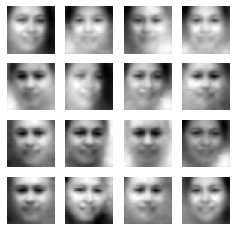

In [48]:
import matplotlib.pyplot as plt

# Create a grid of 4x4 images
n = 4
plt.figure(figsize=(n, n))
for i in range(n * n):
    ax = plt.subplot(n, n, i + 1)
    plt.imshow(decoded_imgs[i].reshape(32, 32), cmap='gray')
    plt.axis('off')

plt.show()

### Sampling from the learned distributions

In [49]:
# Calculate mean and variance of encoder output
z_mean_, z_log_var_, z_ = encoder.predict(x_train)

# Sample from learned distributions using mean and variance of encoder output
epsilon_ = np.random.normal(size=(len(x_train), latent_dim))
z_sample_ = z_mean_ + np.exp(0.5 * z_log_var_) * epsilon_

# Generate new samples from learned distribution 
decoded_imgs_ = decoder.predict(z_sample_)

2711/2711 [==============================] - 7s 2ms/step


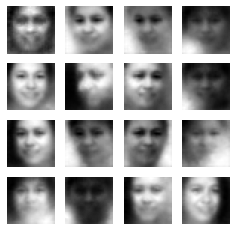

In [50]:
import matplotlib.pyplot as plt

# Create a grid of 4x4 images
n = 4
plt.figure(figsize=(n, n))
for i in range(n * n):
    ax = plt.subplot(n, n, i + 1)
    plt.imshow(decoded_imgs_[i].reshape(32, 32), cmap='gray')
    plt.axis('off')

plt.show()

In [51]:
# Calculate mean and variance of encoder output
z_mean_, z_log_var_, z = encoder.predict(x_train)

# Generate new samples from learned distributions
epsilon_ = np.random.normal(size=(len(x_train), latent_dim))
z_sample_ = z_mean_ + np.exp(0.5 * z_log_var_) * epsilon_

# select 10 random rows
random_rows = np.random.choice(z_sample_.shape[0], size=10, replace=False)

# extract the random rows using fancy indexing
selected_data = z_sample_[random_rows,:]

# Generate new samples from learned distribution using mean and variance of encoder output
generated_imgs_ = decoder.predict(selected_data)

1/1 [==============================] - 0s 18ms/step


In [52]:
random_rows

array([55002, 65182,  5996, 55792, 64153, 73861, 54309, 49696, 82034,
       12116])

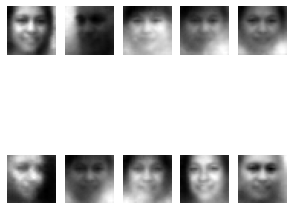

In [53]:
import matplotlib.pyplot as plt

# Create a grid of 4x4 images
n = 2
w = 5
plt.figure(figsize=(5,5))
for i in range(n * w):
    ax = plt.subplot(n, w, i + 1)
    plt.imshow(generated_imgs_[i].reshape(32, 32), cmap='gray')
    plt.axis('off')

plt.show()